In [7]:
import os
import time
import math
import warnings

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem, MACCSkeys, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.DataStructs import TanimotoSimilarity, BulkTanimotoSimilarity
from rdkit.ML.Cluster import Butina

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import pubchempy as pcp

tqdm.pandas()
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

print("Все библиотеки успешно импортированы и настроены.")

Все библиотеки успешно импортированы и настроены.


# 1. Настройка и Загрузка

In [8]:
# Конфигурация путей
RAW_DATA_PATH = '../data/raw/'
PROCESSED_DATA_PATH = '../data/processed/'
CACHE_PATH = '../data/cache/'

# Создаем директории, если их нет
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(CACHE_PATH, exist_ok=True)

# Загрузка исходных данных
try:
    train_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'train_set.csv'))
    test_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'test_set.csv'))
except FileNotFoundError:
    print("Ошибка: Убедитесь, что файлы train_set.csv и test_set.csv находятся в папке ../data/raw/")
    train_df = pd.DataFrame(columns=['PubChem_ID', 'taste_cluster'])
    test_df = pd.DataFrame(columns=['PubChem_ID'])

train_df.rename(columns={'Pubchem_ID': 'PubChem_ID'}, inplace=True)
test_df.rename(columns={'Pubchem_ID': 'PubChem_ID'}, inplace=True)

train_df['PubChem_ID'] = train_df['PubChem_ID'].astype(str)
test_df['PubChem_ID'] = test_df['PubChem_ID'].astype(str)

print("Тренировочные данные:")
print(train_df.head())
print(f"\nРазмер: {train_df.shape}")

print("\nТестовые данные:")
print(test_df.head())
print(f"\nРазмер: {test_df.shape}")

Тренировочные данные:
  PubChem_ID  taste_cluster
0      95609              0
1     104224              0
2    5284499              6
3      10886              4
4   12978217              3

Размер: (2064, 2)

Тестовые данные:
  PubChem_ID
0      32594
1       7130
2       7455
3      31226
4      17000

Размер: (888, 1)


# 2. Получение SMILES из PubChem

In [9]:

def get_smiles_from_pubchem_batched(ids, cache_file, dataset_name):
    """
    Функция для получения SMILES, использующая пакетные запросы.
    """
    print(f"\n--- Обработка {dataset_name} датасета ---")
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)

    # Загрузка кэша
    cached_data = {}
    if os.path.exists(cache_file):
        try:
            cache_df = pd.read_csv(cache_file)
            cache_df.dropna(subset=['SMILES'], inplace=True)
            cached_data = dict(zip(cache_df['PubChem_ID'], cache_df['SMILES']))
        except pd.errors.EmptyDataError:
            pass

    # Определение ID для загрузки
    results = {}
    unique_ids = sorted(list(set(ids)))
    ids_to_fetch = [pid for pid in unique_ids if pid not in cached_data]

    print(f"Всего уникальных ID: {len(unique_ids)}")
    print(f"Найдено в кэше: {len(cached_data)}")
    print(f"Требуется загрузить из PubChem: {len(ids_to_fetch)}")

    # Заполнение результатов из кэша
    for pid, smi in cached_data.items():
        results[pid] = smi

    # Пакетная загрузка недостающих данных
    if ids_to_fetch:
        batch_size = 100  #
        num_batches = math.ceil(len(ids_to_fetch) / batch_size)

        with open(cache_file, 'a', newline='') as f:
            if os.stat(cache_file).st_size == 0:
                f.write('PubChem_ID,SMILES\n')

            for i in tqdm(range(num_batches), desc=f"Загрузка {dataset_name} пачками"):
                batch_ids = ids_to_fetch[i*batch_size : (i+1)*batch_size]
                try:
                    # Один API-запрос на всю пачку
                    compounds = pcp.get_compounds(batch_ids)

                    for compound in compounds:
                        # get_compounds возвращает None для ненайденных ID
                        if compound and compound.smiles:
                            cid = int(compound.cid)
                            smiles = compound.smiles
                            results[cid] = smiles
                            f.write(f'{cid},"{smiles}"\n')
                except Exception as e:
                    print(f"Ошибка при обработке пачки {i+1}/{num_batches}: {e}")

                # Задержка между пачками
                time.sleep(1)
    else:
        print("Все данные уже находятся в кэше.")

    # Сопоставление результатов с исходным порядком ID
    final_smiles = ids.map(results.get).fillna("")
    return final_smiles


# Обработка TRAIN сета
train_smiles_cache_file = os.path.join(CACHE_PATH, 'train_smiles.csv')
initial_train_ids = set(train_df['PubChem_ID'])
initial_train_count = len(train_df)

train_df['SMILES'] = get_smiles_from_pubchem_batched(train_df['PubChem_ID'], train_smiles_cache_file, "Train")

train_df.dropna(subset=['SMILES'], inplace=True)
final_train_ids = set(train_df['PubChem_ID'])
final_train_count = len(train_df)
dropped_train_ids = initial_train_ids - final_train_ids

print("\n--- Отчет по Train датасету ---")
print(f"Исходное количество строк: {initial_train_count}")
print(f"Количество строк после получения SMILES: {final_train_count}")
print(f"Удалено строк: {initial_train_count - final_train_count}")
if dropped_train_ids:
    print(f"Удаленные PubChem_ID: {sorted(list(dropped_train_ids))}")

# Обработка TEST сета
test_smiles_cache_file = os.path.join(CACHE_PATH, 'test_smiles.csv')
initial_test_ids = set(test_df['PubChem_ID'])
initial_test_count = len(test_df)

test_df['SMILES'] = get_smiles_from_pubchem_batched(test_df['PubChem_ID'], test_smiles_cache_file, "Test")

test_df.dropna(subset=['SMILES'], inplace=True)
final_test_ids = set(test_df['PubChem_ID'])
final_test_count = len(test_df)
dropped_test_ids = initial_test_ids - final_test_ids

print("\n--- Отчет по Test датасету ---")
print(f"Исходное количество строк: {initial_test_count}")
print(f"Количество строк после получения SMILES: {final_test_count}")
print(f"Удалено строк: {initial_test_count - final_test_count}")
if dropped_test_ids:
    print(f"Удаленные PubChem_ID: {sorted(list(dropped_test_ids))}")

# Объединение для следующих шагов
full_df = pd.concat([train_df, test_df], ignore_index=True)
print(f"Итоговый размер объединенного датасета: {full_df.shape}")


--- Обработка Train датасета ---
Всего уникальных ID: 2064
Найдено в кэше: 2064
Требуется загрузить из PubChem: 2064


Загрузка Train пачками:   0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 3. Канонизация SMILES

In [10]:

# Инициализируем стандартизаторы
uncharger = rdMolStandardize.Uncharger()
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

def standardize_smiles(smiles):
    """
    Пайплайн стандартизации:
    1. Удаляет соли и фрагменты, оставляя самую большую органическую часть.
    2. Нейтрализует заряды.
    3. Находит канонический таутомер.
    4. Возвращает канонический SMILES с сохранением стереохимии.
    """
    if not isinstance(smiles, str):
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return None

        # Удаление солей/фрагментов
        mol = rdMolStandardize.FragmentParent(mol)

        # Нейтрализация зарядов
        mol = uncharger.uncharge(mol)

        # Приведение к каноническому таутомеру
        mol = tautomer_enumerator.Canonicalize(mol)

        # Возвращаем канонический SMILES, сохраняя стереоинформацию
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except Exception as e:
        print(f"Ошибка стандартизации {smiles}: {e}") # Раскомментировать для отладки
        return None

print("Начинаем полную стандартизацию SMILES...")

full_df['SMILES_standardized'] = full_df['SMILES'].progress_apply(standardize_smiles)


print(f"\nРазмер до удаления пропусков после стандартизации: {len(full_df)}")
full_df.dropna(subset=['SMILES_standardized'], inplace=True)
print(f"Размер после удаления пропусков: {len(full_df)}")

print("\nПример данных после стандартизации:")
print(full_df[['SMILES', 'SMILES_standardized']].head())

Начинаем полную стандартизацию SMILES...


  0%|          | 0/2952 [00:00<?, ?it/s]


Размер до удаления пропусков после стандартизации: 2952
Размер после удаления пропусков: 2952

Пример данных после стандартизации:
  SMILES SMILES_standardized
0                           
1                           
2                           
3                           
4                           


# 4. Расчет дескрипторов

In [11]:
def calculate_rdkit_descriptors(smiles):
    """Считает все 2D дескрипторы из RDKit."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return [np.nan] * len(Descriptors._descList)

        desc_values = [func(mol) for _, func in Descriptors._descList]
        return desc_values
    except Exception:
        return [np.nan] * len(Descriptors._descList)


def calculate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """Считает Morgan Fingerprint """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return [0] * n_bits

        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return list(fp)
    except Exception:
        return [0] * n_bits

def calculate_maccs_fingerprint(smiles):
    """Считает MACCS Fingerprint """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return [0] * 167 # MACCS keys + 1 (нулевой бит не используется)
        fp = MACCSkeys.GenMACCSKeys(mol)
        return list(fp)
    except Exception:
        return [0] * 167

# Расчет дескрипторов RDKit
print("Расчет дескрипторов RDKit")
desc_names = [name for name, _ in Descriptors._descList]
rdkit_features = full_df['SMILES_standardized'].progress_apply(calculate_rdkit_descriptors)
rdkit_df = pd.DataFrame(rdkit_features.tolist(), columns=desc_names, index=full_df.index)

# Расчет фингерпринтов Morgan
print("Расчет фингерпринтов Morgan")
fp_cols = [f'morgan_{i}' for i in range(2048)]
morgan_features = full_df['SMILES_standardized'].progress_apply(calculate_morgan_fingerprint)
morgan_df = pd.DataFrame(morgan_features.tolist(), columns=fp_cols, index=full_df.index)

# Расчет фингерпринтов MACCS
print("Расчет фингерпринтов MACCS")
maccs_cols = [f'maccs_{i}' for i in range(167)]
maccs_features = full_df['SMILES_standardized'].progress_apply(calculate_maccs_fingerprint)
maccs_df = pd.DataFrame(maccs_features.tolist(), columns=maccs_cols, index=full_df.index)

# Объединение и очистка признаков
print("Объединение и очистка признаков")
features_df = pd.concat([rdkit_df, morgan_df, maccs_df], axis=1)

# Удаляем столбцы с постоянным значением (нулевая дисперсия)
const_cols = features_df.columns[features_df.nunique() == 1]
features_df.drop(const_cols, axis=1, inplace=True)
print(f"Удалено {len(const_cols)} столбцов с постоянным значением.")

# Заполняем пропуски медианой (более устойчива к выбросам, чем среднее)
# Также обрабатываем случай, если весь столбец состоит из NaN
features_df.fillna(features_df.median(), inplace=True)
features_df.fillna(0, inplace=True) # Если после медианы остались NaN, заполняем нулями

# Присоединяем признаки к основному датафрейму
full_df_processed = pd.concat([full_df, features_df], axis=1)

print(f"\n Размер датафрейма с признаками: {full_df_processed.shape}")

Расчет дескрипторов RDKit


  0%|          | 0/2952 [00:00<?, ?it/s]

Расчет фингерпринтов Morgan


  0%|          | 0/2952 [00:00<?, ?it/s]

Расчет фингерпринтов MACCS


  0%|          | 0/2952 [00:00<?, ?it/s]

Объединение и очистка признаков
Удалено 2215 столбцов с постоянным значением.

 Размер датафрейма с признаками: (2952, 221)


# 5. Сохранение Промежуточных Результатов

In [12]:
# Разделяем обратно на train и test
train_processed = full_df_processed[full_df_processed['taste_cluster'].notna()].copy()
test_processed = full_df_processed[full_df_processed['taste_cluster'].isna()].copy()

# Сохраняем готовые к обучению файлы
train_output_path = os.path.join(PROCESSED_DATA_PATH, 'train_processed.csv')
test_output_path = os.path.join(PROCESSED_DATA_PATH, 'test_processed.csv')

train_processed.to_csv(train_output_path, index=False)
test_processed.to_csv(test_output_path, index=False)

print(f"\n Обработанные данные сохранены:")
print(f" - Тренировочный сет: {train_output_path} (размер: {train_processed.shape})")
print(f" - Тестовый сет: {test_output_path} (размер: {test_processed.shape})")


 Обработанные данные сохранены:
 - Тренировочный сет: ../data/processed/train_processed.csv (размер: (2064, 221))
 - Тестовый сет: ../data/processed/test_processed.csv (размер: (888, 221))


# 6. Анализ данных

Эталонная молекула для поиска: Ванилин


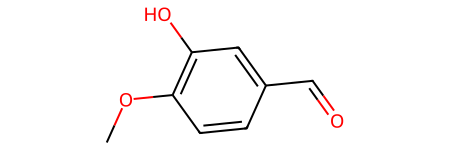


Расчет сходства (Tanimoto) с ванилином


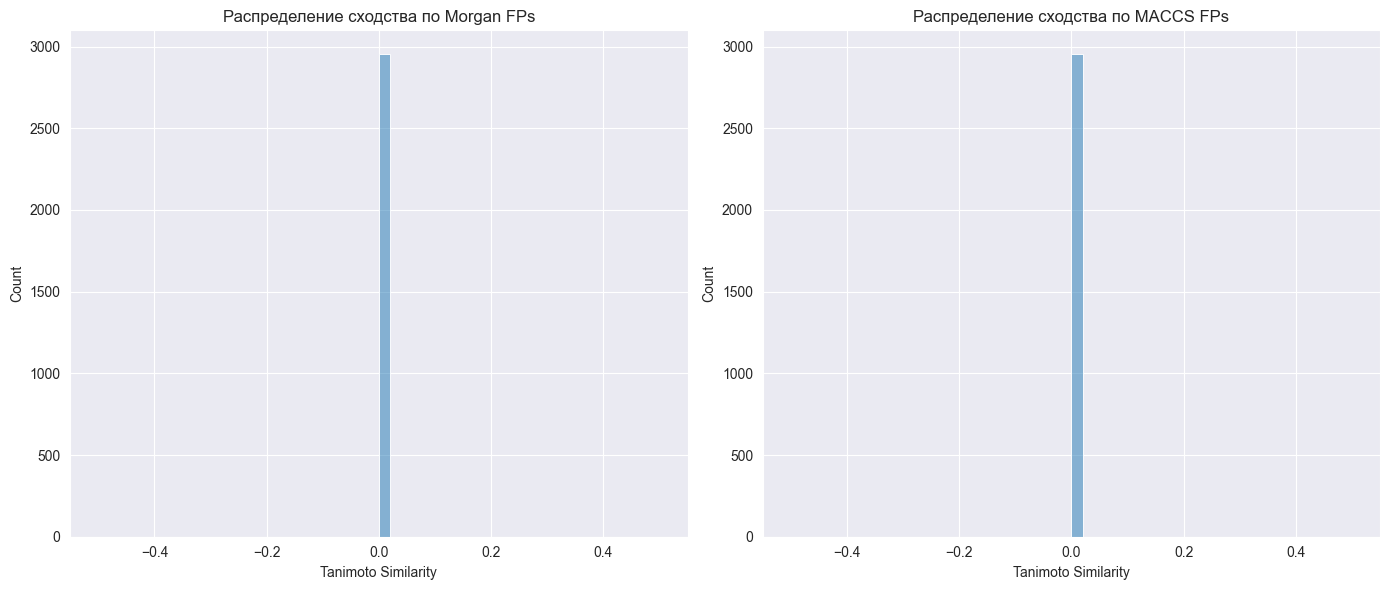


Топ-5 наиболее похожих молекул по Morgan Fingerprints:


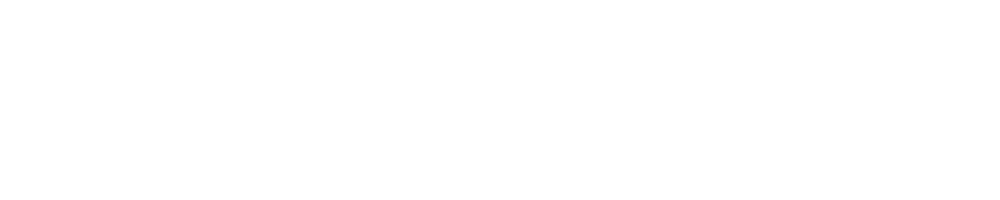


Топ-5 наиболее похожих молекул по MACCS Keys:


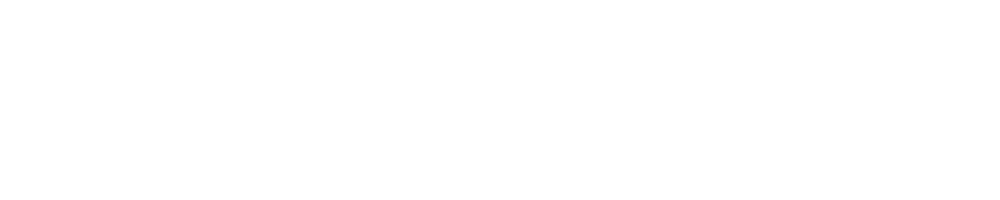

In [13]:
# Выбор эталонной молекулы (Ванилин)
query_smiles = "COC1=C(C=C(C=C1)C=O)O"
query_mol = Chem.MolFromSmiles(query_smiles)
print("Эталонная молекула для поиска: Ванилин")
display(query_mol)

query_morgan_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=2048)
query_maccs_fp = MACCSkeys.GenMACCSKeys(query_mol)

# Расчет сходства для всех молекул в датасете
print("\nРасчет сходства (Tanimoto) с ванилином")

morgan_fp_vects = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in full_df_processed['SMILES_standardized']]
maccs_fp_vects = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in full_df_processed['SMILES_standardized']]

full_df_processed['similarity_morgan'] = [TanimotoSimilarity(query_morgan_fp, fp) for fp in morgan_fp_vects]
full_df_processed['similarity_maccs'] = [TanimotoSimilarity(query_maccs_fp, fp) for fp in maccs_fp_vects]


# Распределение значений сходства
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(full_df_processed['similarity_morgan'], bins=50, kde=True)
plt.title('Распределение сходства по Morgan FPs')
plt.xlabel('Tanimoto Similarity')

plt.subplot(1, 2, 2)
sns.histplot(full_df_processed['similarity_maccs'], bins=50, kde=True)
plt.title('Распределение сходства по MACCS FPs')
plt.xlabel('Tanimoto Similarity')
plt.tight_layout()
plt.show()

# Визуализация наиболее похожих молекул
print("\nТоп-5 наиболее похожих молекул по Morgan Fingerprints:")
top_5_morgan = full_df_processed.sort_values('similarity_morgan', ascending=False).head(5)
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in top_5_morgan['SMILES_standardized']]

legends = []
for sim, c in zip(top_5_morgan['similarity_morgan'], top_5_morgan['taste_cluster']):
    cluster_label = int(c) if pd.notna(c) else "Test" #
    legends.append(f"Sim: {sim:.2f}, Clust: {cluster_label}")

display(Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, legends=legends))


print("\nТоп-5 наиболее похожих молекул по MACCS Keys:")
top_5_maccs = full_df_processed.sort_values('similarity_maccs', ascending=False).head(5)
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in top_5_maccs['SMILES_standardized']]

legends = []
for sim, c in zip(top_5_maccs['similarity_maccs'], top_5_maccs['taste_cluster']):
    cluster_label = int(c) if pd.notna(c) else "Test"
    legends.append(f"Sim: {sim:.2f}, Clust: {cluster_label}")

display(Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, legends=legends))

if 'morgan_fp_vect' in full_df_processed.columns:
    full_df_processed = full_df_processed.drop(columns=['morgan_fp_vect'])
if 'maccs_fp_vect' in full_df_processed.columns:
    full_df_processed = full_df_processed.drop(columns=['maccs_fp_vect'])

Запускаем кластеризацию Butina


Расчет матрицы расстояний:   0%|          | 0/2951 [00:00<?, ?it/s]

Найдено 1 структурных кластеров (с порогом Tanimoto > 0.1)

Топ-10 крупнейших структурных кластеров:
butina_cluster
0    2064
Name: count, dtype: int64


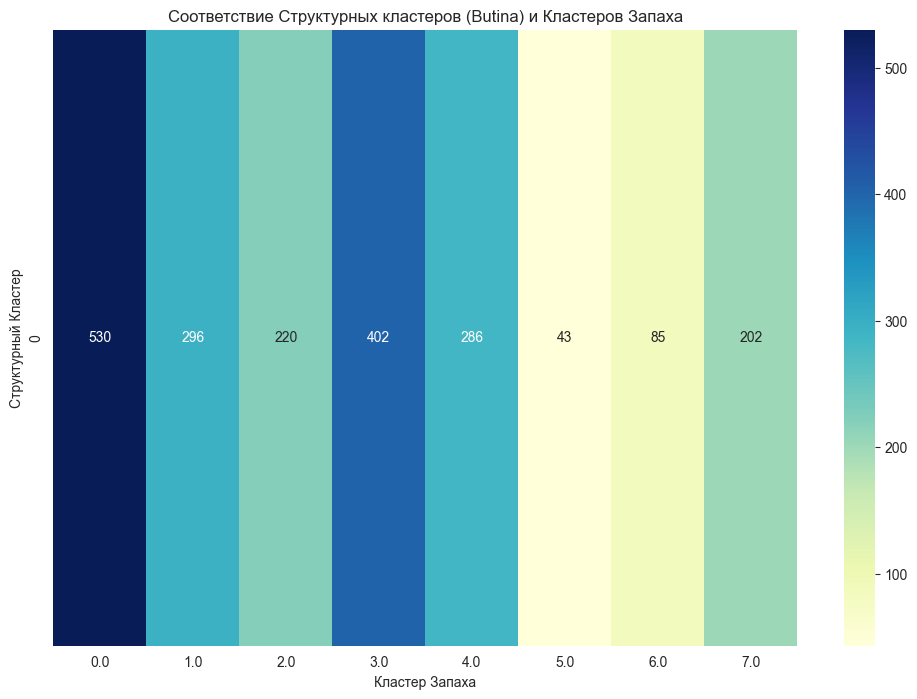

In [14]:
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in full_df_processed['SMILES_standardized']]
n_fps = len(fps)

def butina_cluster(fp_list, cutoff_dist):
    """
    Кластеризует отпечатки с помощью алгоритма Butina.
    Использует BulkTanimotoSimilarity для расчета расстояний.
    """
    dists = []
    for i in tqdm(range(1, len(fp_list)), desc="Расчет матрицы расстояний"):
        sims = BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Преобразуем сходство в расстояние (1 - similarity)
        dists.extend([1 - s for s in sims])

    # Кластеризация по матрице расстояний
    clusters = Butina.ClusterData(dists, len(fp_list), cutoff_dist, isDistData=True)
    return clusters

print("Запускаем кластеризацию Butina")
clusters = butina_cluster(fps, 0.6)
print(f"Найдено {len(clusters)} структурных кластеров (с порогом Tanimoto > 0.1)")

cluster_ids = np.zeros(n_fps, dtype=int)
for i, cluster in enumerate(clusters):
    for member_idx in cluster:
        cluster_ids[member_idx] = i
full_df_processed['butina_cluster'] = cluster_ids

train_processed = full_df_processed[full_df_processed['taste_cluster'].notna()].copy()

print("\nТоп-10 крупнейших структурных кластеров:")
print(train_processed['butina_cluster'].value_counts().head(10))

# Визуализация соответствия
top_butina_clusters = train_processed['butina_cluster'].value_counts().head(15).index
df_subset = train_processed[train_processed['butina_cluster'].isin(top_butina_clusters)]

crosstab = pd.crosstab(df_subset['butina_cluster'], df_subset['taste_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, cmap="YlGnBu", annot=True, fmt='d')
plt.title('Соответствие Структурных кластеров (Butina) и Кластеров Запаха')
plt.xlabel('Кластер Запаха')
plt.ylabel('Структурный Кластер')
plt.show()

In [15]:
# Функция для расчета обогащения
def get_enrichment_stats(df, target_cluster, fp_type='morgan'):
    """
    Рассчитывает и возвращает факторы обогащения (EF) для заданного кластера.
    """
    cluster_df = df[df['taste_cluster'] == target_cluster]
    if len(cluster_df) < 2:
        return None  # Невозможно выбрать центр и провести анализ

    # Определяем центральную молекулу кластера
    if fp_type == 'morgan':
        cluster_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in cluster_df['SMILES_standardized']]
    else: # maccs
        cluster_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in cluster_df['SMILES_standardized']]

    sim_matrix = np.zeros((len(cluster_fps), len(cluster_fps)))
    for i in range(len(cluster_fps)):
        sim_matrix[i, :] = BulkTanimotoSimilarity(cluster_fps[i], cluster_fps)

    center_idx = np.argmax(sim_matrix.sum(axis=1))
    query_fp = cluster_fps[center_idx]

    # Рассчитываем сходство всего датасета с центральной молекулой
    if fp_type == 'morgan':
        all_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in df['SMILES_standardized']]
    else: # maccs
        all_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in df['SMILES_standardized']]

    df['similarity_to_center'] = [TanimotoSimilarity(query_fp, fp) for fp in all_fps]

    # Сортируем и считаем обогащение
    df_sorted = df.sort_values('similarity_to_center', ascending=False).reset_index(drop=True)
    hits = (df_sorted['taste_cluster'] == target_cluster).cumsum()
    total_hits = (df['taste_cluster'] == target_cluster).sum()

    # Функция для расчета EF на заданном проценте
    def calculate_ef_at_percent(p):
        idx = max(1, int(len(df) * p))
        if idx >= len(hits): return np.nan

        hits_at_p = hits[idx - 1]
        ef = (hits_at_p / idx) / (total_hits / len(df))
        return ef

    return {
        'EF1%': calculate_ef_at_percent(0.01),
        'EF5%': calculate_ef_at_percent(0.05)
    }

results = []
unique_clusters = sorted(train_processed['taste_cluster'].unique())

print(f"Анализируем обогащение для {len(unique_clusters)} кластеров")
for cluster_id in tqdm(unique_clusters, desc="Анализ кластеров"):
    cluster_size = (train_processed['taste_cluster'] == cluster_id).sum()

    # Анализ для Morgan
    morgan_stats = get_enrichment_stats(train_processed.copy(), cluster_id, 'morgan')
    if morgan_stats:
        results.append({
            'taste_cluster': int(cluster_id),
            'cluster_size': cluster_size,
            'fp_type': 'Morgan',
            'EF1%': morgan_stats['EF1%'],
            'EF5%': morgan_stats['EF5%']
        })

    # Анализ для MACCS
    maccs_stats = get_enrichment_stats(train_processed.copy(), cluster_id, 'maccs')
    if maccs_stats:
        results.append({
            'taste_cluster': int(cluster_id),
            'cluster_size': cluster_size,
            'fp_type': 'MACCS',
            'EF1%': maccs_stats['EF1%'],
            'EF5%': maccs_stats['EF5%']
        })

results_df = pd.DataFrame(results).round(2)

# Находим лучший тип отпечатка для каждого кластера по EF1%
best_fp_df = results_df.loc[results_df.groupby('taste_cluster')['EF1%'].idxmax()]
best_fp_df = best_fp_df.sort_values('EF1%', ascending=False).reset_index(drop=True)

print(" Лучший тип отпечатка для каждого кластера (по EF1%)")

display(best_fp_df)

print("\nEF (Enrichment Factor) показывает, во сколько раз поиск по сходству эффективнее случайного выбора.")
print("Высокое значение EF (>10) означает, что молекулы в кластере структурно однородны.")

Анализируем обогащение для 8 кластеров


Анализ кластеров:   0%|          | 0/8 [00:00<?, ?it/s]

 Лучший тип отпечатка для каждого кластера (по EF1%)


,taste_cluster,cluster_size,fp_type,EF1%,EF5%
0,2,220,Morgan,1.88,0.82
1,0,530,Morgan,1.17,0.98
2,4,286,Morgan,1.08,0.91
3,3,402,Morgan,1.03,1.25
4,1,296,Morgan,0.70,1.02
5,7,202,Morgan,0.51,0.89
6,5,43,Morgan,0.00,1.40
7,6,85,Morgan,0.00,0.71



EF (Enrichment Factor) показывает, во сколько раз поиск по сходству эффективнее случайного выбора.
Высокое значение EF (>10) означает, что молекулы в кластере структурно однородны.
